<a href="https://colab.research.google.com/github/roydcapella/convnet2/blob/collab/resnet_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*   Universidad de Chile
*   Postitulo IA
*   Computer Vision
*   Roydith Capella

# Resumen
En este documento se encuentran los resultados obtenidos al momento de experimentar con arquitecturas de redes neuronales convulacionales especificamente ResNet-34 y  AlexNet utilizando el dataset Clothing aplicando métodos de optimización tales como Descenso de Gradiente Estocástico (SGD) y Estimación del Momento Adaptativo (ADAM) para medir sus efectos en el proceso de aprendizaje.

# Introduccion

Una  red  de  neuronal es  un modelo  matemático  formado  por  una  serie  de  operaciones  que,  para  un vector  de  entrada  x, ofrece  un  vector de  salida  distinto f(x).

Las neuronas se organizan en capas, donde cada una se conecta con todas las de la capa siguiente. En esta arquitectura, cada conexión tiene asociado un peso, por lo  que  la  principal  operación  que  se  realiza  esuna  multiplicación  entre  el valor  de  la  neurona  y  el  de  su  conexión  saliente.  De  esta  manera,  las neuronas de las capas siguientes reciben los resultados anteriores sumados en uno y aplican funciones no lineales para producir un nuevo resultado. 

Uno  de  los  tipos  más  populares  de  redes  neuronales son  las conocidas  como  redes  neuronales  convolucionales que tienen como principal caracteristica el hecho de que cada neurona de una capa no recibe  conexiones  de todas  las  neuronas  de  la  capa anterior,  sino  sólo  de algunas, favoreciendo que cada neurona se especialice en una región de la lista de códigos de la capa anterior, reduciendo drásticamente el número de pesos y de multiplicaciones necesarias

AlexNet es una red neuronal convolucional pre-entrenada que compitió en ImageNet en 2012, un desafío a gran escala de reconocimiento visual en el que consiguió una tasa de error del 15,3%, 10.8 puntos por encima del otro finalista.Alexnet contiene  ochos  capas:  las  cinco  primeras  son  convolucionales, mientras que las tres son Fully Connected Layer. 

En cambio, la redes residuales o ResNet se inspiran en el hecho biológico de que algunas neuronas se conectan con neuronas en capas no necesariamente contiguas, saltando capas intermedias aumentando el número de capas al introducir una conexión residual con una capa identidad, la cual pasa a la siguiente directamente. 
De esta forma permitio entrenar por primera vez redes de más de 100 capas controlando con éxito el problema del Desvanecimiento de Gradiente, propuesta por  Kaiming He y Microsoft en 2015, ganando la ILSVRC (ImageNet Large Scale Visual Recognition Challenge) por sus aportes significativos

En este trabajo conoceremos como pueden ser implementadas y las principales diferencias al aplicar distintos tipos de optimizacion, especificamente, SGD y ADAM

# **Configurando entorno**

In [48]:
print ("Connecting to Google Drive...")

#from google.colab import drive
#Which folder do you wish install?
#drive.mount('/content/drive/')


'''
!pip install -r requirements.txt
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
     '''

Connecting to Google Drive...


'\n!pip install -r requirements.txt\nfrom google.colab import files\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n     '

### Importando repositorio

In [1]:
!pwd
!rm -Rf convnet2/

!git clone https://github.com/roydcapella/convnet2.git

%cd convnet2/
!git checkout collab

/content
Cloning into 'convnet2'...
remote: Enumerating objects: 359, done.
remote: Counting objects: 100% (359/359), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 359 (delta 214), reused 316 (delta 177), pack-reused 0
Receiving objects: 100% (359/359), 24.52 MiB | 5.58 MiB/s, done.
Resolving deltas: 100% (214/214), done.
/content/convnet2
Branch 'collab' set up to track remote branch 'collab' from 'origin'.
Switched to a new branch 'collab'




---



# **Algunos metodos**
Estos seran utilizados mas adelante

In [2]:
##importando algunas dependencias
import numpy as np
import argparse
import os
import matplotlib as plt
import pickle
from matplotlib import pyplot as plt

def plotAccuracyLoss(name, training_file):
    """Imprime la comparativa entre Accuracy y Loss para el entrenamiento de un modelo dado
      Parámetros:
        name -- Nombre del modelo 
        training_file -- ubicacion del archivo que quiere ser pintado
      Excepciones:
      FileNotFoundError -- Si el archivo historico no ha sido encontrado
      """
    with open(training_file, 'rb') as handle: 
      tr = pickle.load(handle)
    print ("Printing " + name)
    plt.figure(figsize=(20,5))
    plt.suptitle(name)
    plt.subplot(1,2,2)
    plt.xlabel('# Epocas')
    plt.legend(loc="upper right", title="Accuracy", frameon=False)
    plt.plot(tr['accuracy'], label ='train_accuracy')
    plt.plot(tr['val_accuracy'], label ='val_accuracy')
    plt.subplot(1,2,1)
    plt.xlabel('# Epocas')
    plt.legend(loc="lower right", title="Loss", frameon=False)
    plt.plot(tr['loss'], label ='train_loss')
    plt.plot(tr['val_loss'], label ='val_loss')
    plt.show()

def plotMultipleAccuracyLoss(name, training_history):
    plt.figure(figsize=(20,5))
    plt.suptitle(name)
    plt.subplot(1,2,1)
    plt.xlabel('Época')
    plt.legend(loc="upper right", title="Loss", frameon=False)
    plt.subplot(1,2,2)
    plt.xlabel('Época')
    plt.legend(loc="lower right", title="Accuracy", frameon=False)

    for training in training_history:
      model = training[0]
      filename = training[1]
      with open(filename, 'rb') as handle: 
        tr = pickle.load(handle)
      plt.subplot(1,2,1)
      plt.plot(tr['val_loss'], label = model + 'loss')
      plt.subplot(1,2,2)
      plt.plot(tr['val_accuracy'], label = model + 'accuracy')
    plt.show()

def loadModel(ccn, checkpoint):
  number_of_classes = configuration.get_number_of_classes()
  model = AlexNetModel(number_of_classes)
  model(input_image)    
  model.summary()
  model.load_weights(checkpoint)                                     
  model.compile(optimizer=optAdam,loss= crossentropy_loss,metrics=['accuracy'])    


# **Preparando datos**

## Desde cero
Solo requerido si se desea crear un nuevo tfrecords


### Descargando datasets

In [ ]:
#Obtenemos nuestos datasets y lo posicionamos en la raiz de nuestro proyecto

!echo "downloading dataset... "
!wget https://www.dropbox.com/s/c3h9e0o6ajydbao/clothing-small.zip

!unzip -uq 'clothing-small.zip' -d '.'
!rm clothing-small.zip
!mv ./clothing-small/* .
!mv test_sample.txt test.txt
!mv train_sample.txt train.txt


### Generando secuencia de registros binarios (TF Records)

In [ ]:
#running with CLOTHING_SMALL_BASE
!python ./datasets/create_tfrecords.py -type all -config configs/clothing-small-base.config -name CLOTHING_SMALL_BASE


## Cargando TF Records

> Si se ha configurado un tfrecords esta es la mejor opcion para no partir de cero y aprovechar el tiempo



### Descargando TF Records

In [ ]:
#Obtenemos un tf records+
!echo "downloading tf-records... "
!wget https://www.dropbox.com/s/c3h9e0o6ajydbao/tf-records.zip
!mv 'tf-records.zip' data/
!unzip -uq 'data/tf-records.zip' -d 'data/'
!rm "data/tf-records.zip"


### Cargando en memoria TF Records

In [ ]:
#

# **Fase de entrenamiento**:


## Desde cero
Solo si es requerido volver a entrenar y validar nuestros modelos

### *Resnet*


**Stochastic gradient descent (SGD)**

In [ ]:
!python train_selected.py -config configs/clothing-small-sgd.config -arch resnet -name CLOTHING_SMALL_SGD -method sgd -mode train -save True
#!python train_selected.py -config configs/clothing-small-sgd-optimal.config -arch resnet  -name CLOTHING_SMALL_SGD_OPTIMAL -method sgd -mode train -save True


python3: can't open file 'train_selected.py': [Errno 2] No such file or directory


**Adaptive Moment Estimation (Adam)** 

In [ ]:
!python train_selected.py -config configs/clothing-small-adam.config -arch resnet -name CLOTHING_SMALL_ADAM -method adam -mode train -save True


### *Alexnet*


**Stochastic gradient descent (SGD)**

In [ ]:
!python train_selected.py -config configs/clothing-small-sgd.config -arch alexnet -name CLOTHING_SMALL_SGD -method sgd -mode train -save True
#!python train_selected.py -config configs/clothing-small-sgd-optimal.config -arch alexnet  -name CLOTHING_SMALL_SGD_OPTIMAL -method sgd -mode test

python3: can't open file 'train_selected.py': [Errno 2] No such file or directory


**Adaptive Moment Estimation (Adam)** 

In [ ]:
!python train_selected.py -config configs/clothing-small-adam.config -arch alexnet -name CLOTHING_SMALL_ADAM -method adam -mode train -save True



---



## Desde modelos ya creados
Dado que tenemos algunos modelos preentrenados podemos utilizarlos para generar nuestras metricas y predecir nuestros resultados


In [3]:
#Obtenemos un tf records+
!echo "downloading models... "
#!wget https://www.dropbox.com/s/xrghihzd7xokqlw/models.zip
!mv 'models.zip' ./data/
!unzip -uq 'data/models.zip' -d 'data/'
!rm "data/models.zip"

downloading models... 
--2020-11-15 01:07:39--  https://www.dropbox.com/s/xrghihzd7xokqlw/models.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xrghihzd7xokqlw/models.zip [following]
--2020-11-15 01:07:40--  https://www.dropbox.com/s/raw/xrghihzd7xokqlw/models.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0ed38b8d167a61eadf3549e545.dl.dropboxusercontent.com/cd/0/inline/BDOzMTQNeuSHY9XMvzUBXbomQoHEKvAo4IW9NO7rnFAstE04NkrklUXhq90a57vD8b8viothKh_Ki-spql7vMzNZBk-FkzqxaQDtWVY-jY61k2AJM9o_rETiky6Q2A786gI/file# [following]
--2020-11-15 01:07:40--  https://uc0ed38b8d167a61eadf3549e545.dl.dropboxusercontent.com/cd/0/inline/BDOzMTQNeuSHY9XMvzUBXbomQoHEKvAo4IW9NO7rnFAstE04NkrklUXhq90a57vD8b8viothKh_Ki-spql7vMzNZBk-Fkz

## Analizando entrenamientos


### *Resnet*


**Stochastic gradient descent (SGD)**

In [ ]:
plotAccuracyLoss("Resnet SGD", "data/models/resnet/sgd/training.txt")

**Adaptive Moment Estimation (Adam)** 

In [ ]:
plotAccuracyLoss("Resnet ADAM", "data/models/resnet/adam/training.txt")

### *Alexnet*


**Stochastic gradient descent (SGD)**

In [ ]:
plotAccuracyLoss("Alexnet SGD", "data/models/alexnet/sgd/training.txt")

**Adaptive Moment Estimation (Adam)** 

In [ ]:
plotAccuracyLoss("Alexnet ADAM", "data/models/alexnet/adam/training.txt")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Imprimiendo valores de entrenamiento usando Alexnet
Printing Alexnet ADAM


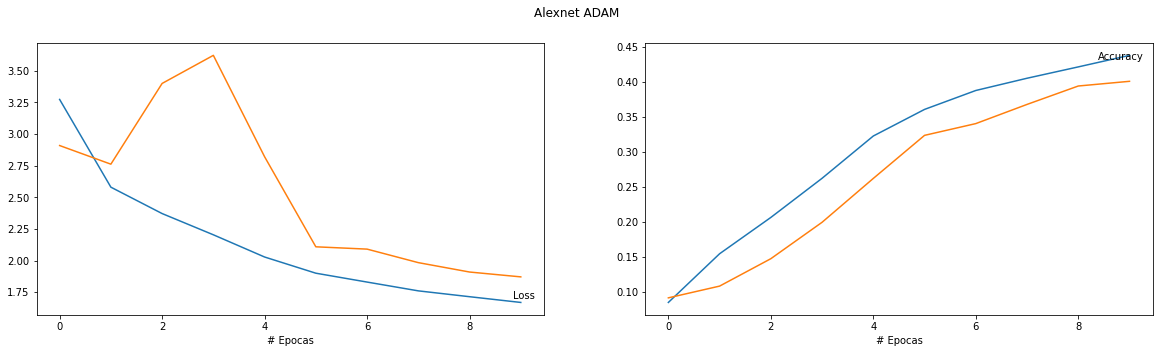

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Printing Alexnet SGD


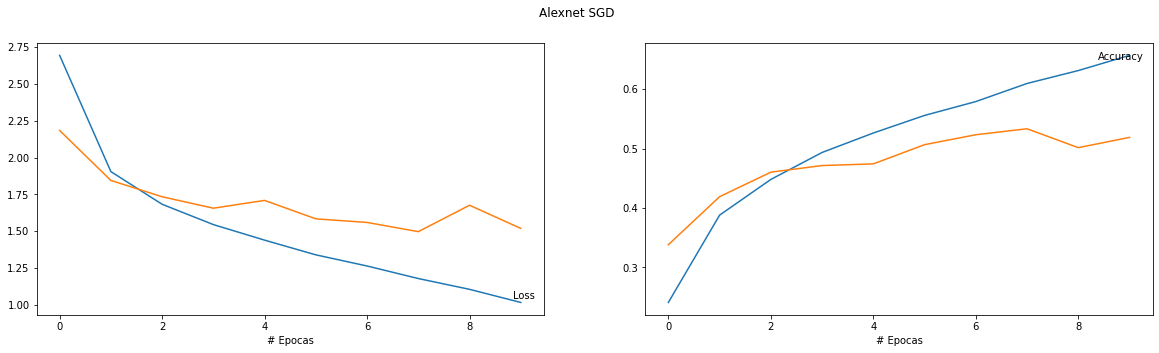

In [ ]:
print ("Comparando optimizadores en Alexnet")


### Conclusiones

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Comparativa General para Resnet y Alexnet


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


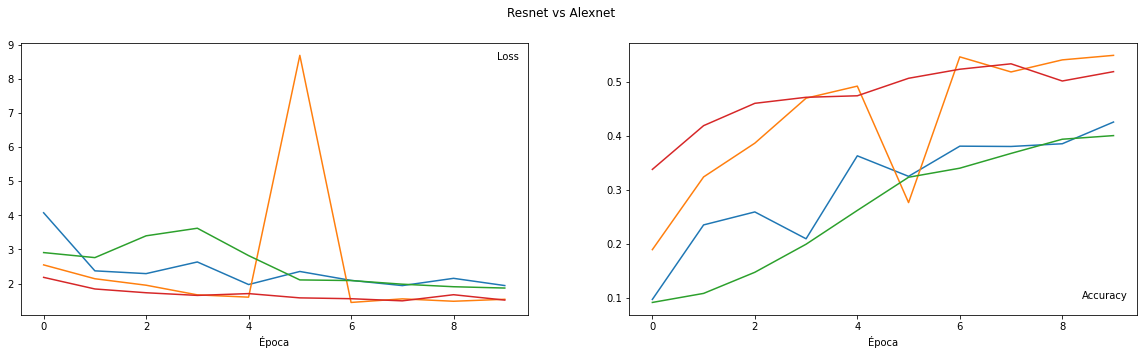

In [ ]:
training_history = [("Resnet ADAM", "models/resnet/adam/training.txt"), 
                    ("Resnet SGD", "models/resnet/sgd/training.txt"),
                    ("Alexnet ADAM", "models/alexnet/adam/training.txt"), 
                    ("Alexnet SGD", "models/alexnet/sgd/training.txt"),
                    ]



# **Fase de validacion**

# **Predicciones**

# **Comentarios finales**
